# # Exploratory Analysis on Strava Metro Data for Maricopa County

In [2]:
import pandas as pd
import fiona
import geopandas as gpd
import pysal as ps
import sklearn
import sys,os
import matplotlib.pyplot as plt
import mplleaflet
%matplotlib inline
import numpy as np
print("Importing packages..")

Importing packages..


#### Let us take a quick look at the entire dataset and try to visualise it on a map..

In [5]:
ride_data = "C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/maricopa_2016_ride/"
official_counts = "C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/MAG_Official_Counts/MAG2015_16/"
%time mag2016_edges_strava = gpd.read_file(ride_data+"Edges/maricopa_osm_edges.shp")
%time mag2016_nodes_strava = gpd.read_file(ride_data+"Nodes/maricopa_osm_edges_nodes.shp")
%time mag2016_od_poly_strava = gpd.read_file(ride_data+"OD/maricopa_edges_od_polygons.shp")
print("\n\nNo. of Streets in Maricopa County = " + str(mag2016_edges_strava.shape[0]),
      "\nNo. of street intersections = " + str(mag2016_nodes_strava.shape[0]),
      "\nNo. of OD polygons = " + str(mag2016_od_poly_strava.shape[0]))

Wall time: 1min 10s
Wall time: 20.2 s
Wall time: 865 ms
('\n\nNo. of Streets in Maricopa County = 498930', '\nNo. of street intersections = 372466', '\nNo. of OD polygons = 2343')


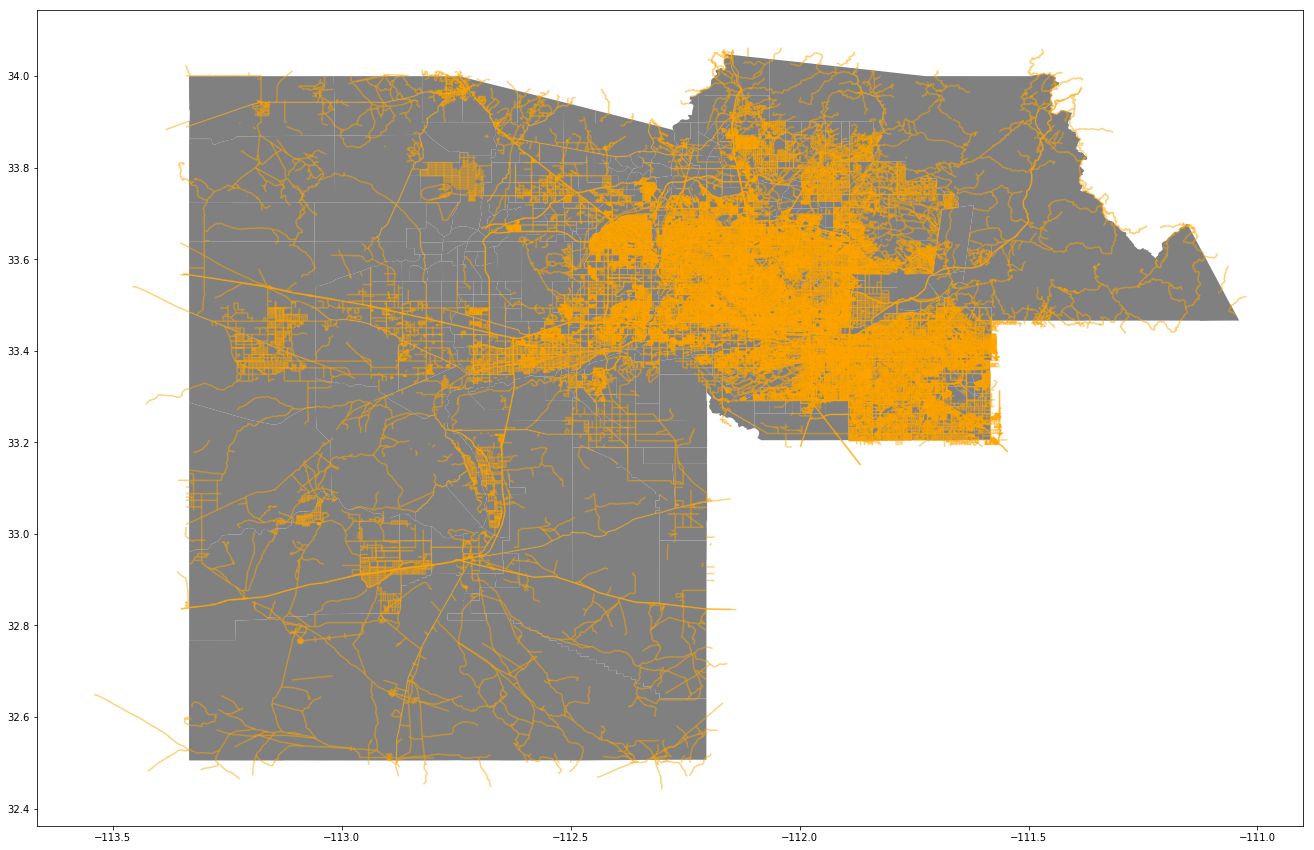

In [64]:
ax = mag2016_od_poly_strava.plot(color='grey', figsize = ([25,15]))
mag2016_edges_strava.plot(ax=ax, color='orange', alpha=0.5, figsize = ([25,15]))

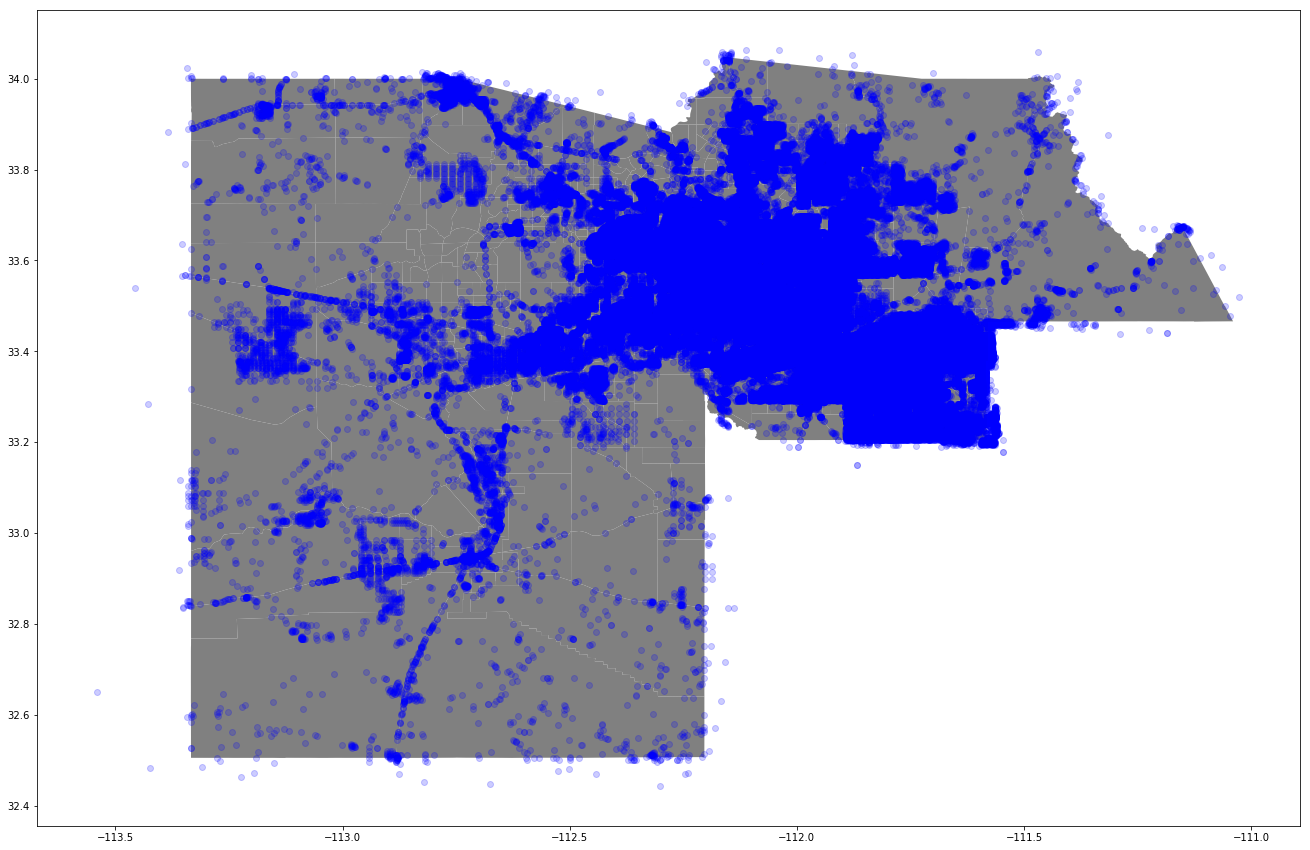

In [65]:
ax = mag2016_od_poly_strava.plot(color='grey', figsize = ([25,15]))
mag2016_nodes_strava.plot(ax=ax, color ='blue', alpha=0.2, figsize = ([25,15]))

In [5]:
mag2016_edges_strava.head()

,ID,OSM_ID,OSM_NAME,OSM_META,OSM_SOURCE,OSM_TARGET,CLAZZ,FLAGS,SOURCE,TARGET,KM,KMH,COST,REVERSE_CO,X1,Y1,X2,Y2,geometry
0,1,2901206.0,,,1.947858e+08,2.562028e+08,12.0,3.0,625.0,626.0,0.183385,30.0,0.006113,1000000.000000,-112.042513,33.461522,-112.040552,33.461314,"LINESTRING (-112.0425132 33.4615216, -112.0411..."
1,44,5560497.0,Encanto Drive Southeast,,4.119055e+07,1.515773e+09,32.0,3.0,658.0,365869.0,0.153708,50.0,0.003074,0.003074,-112.083528,33.471228,-112.084298,33.470257,"LINESTRING (-112.0835284 33.471228, -112.08353..."
2,45,5560497.0,Encanto Drive Southeast,,1.515773e+09,4.119055e+07,32.0,3.0,365869.0,659.0,0.051721,50.0,0.001034,0.001034,-112.084298,33.470257,-112.084855,33.470254,"LINESTRING (-112.0842976 33.4702568, -112.0848..."
3,46,5560498.0,South Apalosa Drive,,4.119057e+07,4.119057e+07,32.0,3.0,660.0,94373.0,0.185933,50.0,0.003719,0.003719,-111.976541,33.387129,-111.976576,33.388799,"LINESTRING (-111.9765412 33.387129, -111.97660..."
4,47,5560498.0,South Apalosa Drive,,4.119057e+07,4.119057e+07,32.0,3.0,94373.0,661.0,0.210952,50.0,0.004219,0.004219,-111.976576,33.388799,-111.976533,33.390691,"LINESTRING (-111.9765756 33.3887988, -111.9764..."


In [6]:
mag2016_nodes_strava.head()

,ID,geometry
0,1,POINT (-113.540986 32.649619)
1,2,POINT (-113.455974 33.540419)
2,3,POINT (-113.427562 33.283132)
3,4,POINT (-113.423601 32.481674)
4,5,POINT (-113.3849176 33.88291)


In [7]:
mag2016_od_poly_strava.head()

,OBJECTID,TAZ,ASU_CAMPUS,ACREAGE,SHAPE_STAR,SHAPE_STLE,geometry
0,1,101.0,,63959.0,2.786042e+09,227682.125722,POLYGON ((-113.0098654982331 33.46730468828151...
1,2,3173.0,,3833.0,1.669786e+08,58019.657493,POLYGON ((-112.7676100066842 33.42100021852587...
2,3,103.0,,28667.0,1.248729e+09,183509.999835,POLYGON ((-112.7127116703171 33.32036176337967...
3,13,113.0,,2100.0,9.147175e+07,42022.258392,POLYGON ((-112.6514797601934 33.63881407468497...
4,1501,1435.0,,957.0,4.169027e+07,26387.277105,POLYGON ((-111.7875323316803 33.46813281475666...


In [66]:
#Read the bike counts data from strava
%time strava_2016_ride_nodes_rollup_total = pd.read_csv(ride_data+"Nodes/maricopa_2016_ride_nodes_rollup_total.csv")
%time strava_2016_ride_edges_rollup_total = pd.read_csv(ride_data+"Edges/maricopa_2016_ride_rollup_total.csv")

print("Strava Bike Counts for nodes = " + str(strava_2016_ride_nodes_rollup_total.shape[0]), 
      "\nStrava Bike Counts for edges = " + str(strava_2016_ride_edges_rollup_total.shape[0]))

CPU times: user 3.02 s, sys: 303 ms, total: 3.33 s
Wall time: 3.67 s
CPU times: user 4.29 s, sys: 456 ms, total: 4.74 s
Wall time: 5.5 s
Strava Bike Counts for nodes = 296811 
Strava Bike Counts for edges = 344024


In [9]:
strava_2016_ride_nodes_rollup_total['athcnt'].describe()

count    296811.000000
mean        100.333350
std         248.068188
min           1.000000
25%           3.000000
50%          10.000000
75%          59.000000
max        3966.000000
Name: athcnt, dtype: float64

In [10]:
strava_2016_ride_edges_rollup_total['athcnt'].describe()

count    344024.000000
mean         45.850624
std         132.350497
min           0.000000
25%           1.000000
50%           4.000000
75%          20.000000
max        2630.000000
Name: athcnt, dtype: float64

In [67]:
#Read Origin/Destination Data
strava_2016_ride_OD = pd.read_csv(ride_data+"OD/maricopa_osm_edges_metro_od_data.csv")
strava_2016_ride_OD.head(10)

,polygon_id,year,day,hour,minute,commute,dest_polygon_id,intersected_polygons
0,334,2016,48,11,29,1,261,"{327,163,328,251,254,261,264,310,311,312,313,3..."
1,334,2016,52,9,44,0,334,"{334,327,328,324,331}"
2,334,2016,59,10,36,0,334,"{327,158,157,328,329,240,243,244,245,263,248,2..."
3,334,2016,60,11,12,1,325,"{334,327,328,324,325,331}"
4,334,2016,116,16,49,1,2894,"{333,334,2894,2896,2897}"
5,334,2016,136,8,5,0,334,"{327,328,260,326,323,324,330,331,2900,2901,290..."
6,334,2016,153,6,56,0,334,"{327,328,260,326,323,324,330,331,2898,2900,289..."
7,334,2016,155,6,57,0,334,"{260,326,323,330,331,2898,2900,2899}"
8,334,2016,202,5,26,1,330,"{334,330,331}"
9,334,2016,204,17,14,0,334,"{334,861,327,328,324,331,857,2906}"


In [68]:
pd.unique(strava_2016_ride_OD[['polygon_id','year','day','hour','minute','dest_polygon_id','intersected_polygons','commute']].values.ravel()).shape

(261792,)

#### Strava has provided a minute-by-minute count of bike riders along all the streets and intersections in Maricopa County for 2016. We try to plot a timeseries for a subset of the data below.

In [69]:
# Count of minute by minute Strava rides along edges
mag_strava_min_to_min_edges = pd.read_csv(ride_data + "Edges/maricopa_osm_edges_metro_edges_data.csv")
# Count of minute by minute Strava rides along intersections
mag_strava_min_to_min_nodes = pd.read_csv(ride_data + "Nodes/maricopa_osm_edges_metro_nodes_data.csv")
print("Total no. of minute to minute Strava rides in 2016 along streets in Maricopa County = " + str(mag_strava_min_to_min_edges.shape[0]))
print("\nTotal no. of minute to minute Strava rides in 2016 at intersections in Maricopa County =" + str(mag_strava_min_to_min_nodes.shape[0]))

Total no. of minute to minute Strava rides in 2016 along streets in Maricopa County = 68469637

Total no. of minute to minute Strava rides in 2016 at intersections in Maricopa County =99784569


#### Now let us read the official bike counts from maricopa for 2016 and visualise the counts

In [70]:

mag2015_16_official = gpd.read_file(official_counts + "Bike_Counts_2015_16.shp")
print("No. of Official bike count Sites = "+ str(mag2015_16_official.shape[0])) 

No. of Official bike count Sites = 44


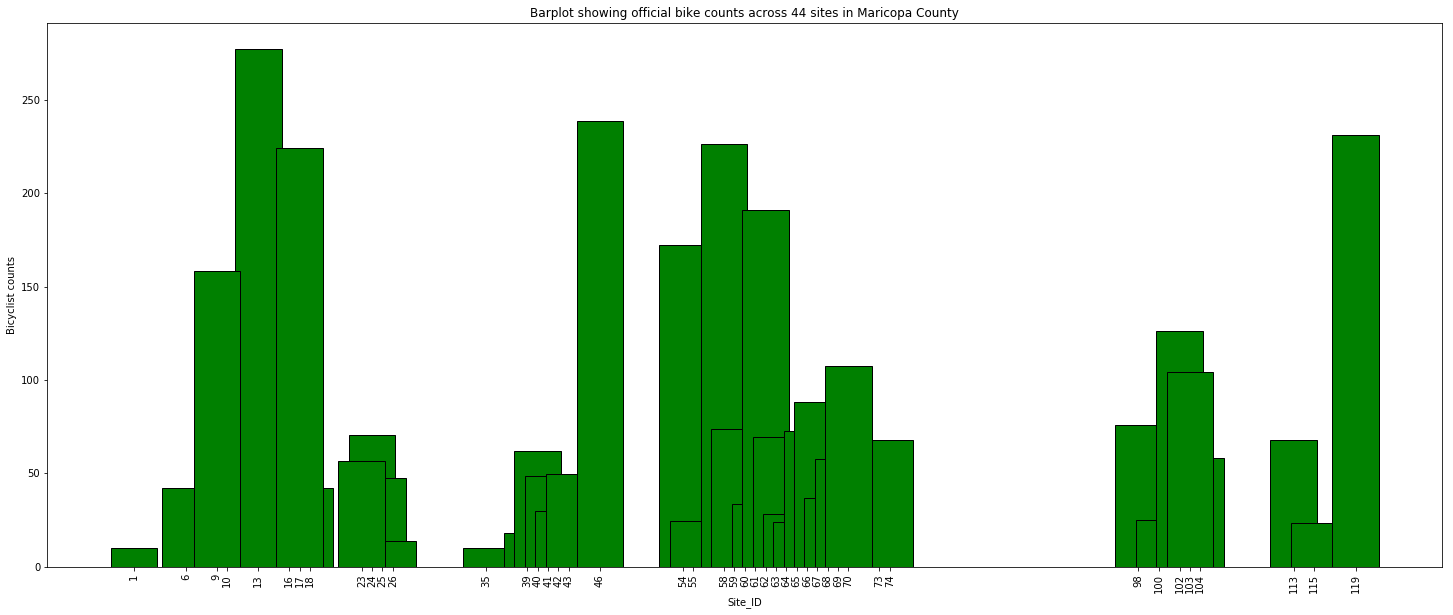

In [84]:
# Plot a bar graph to display counts accross sites
counts = mag2015_16_official.Avg_TWR
sites = mag2015_16_official.Site_ID
plt.figure(figsize=([25,10]))
plt.bar(sites,counts,width = 4.5 , color='green',edgecolor='black')
plt.ylabel('Bicyclist counts')
plt.xlabel("Site_ID")
plt.title('Barplot showing official bike counts across 44 sites in Maricopa County')
plt.xticks(sites, rotation = 90)
plt.show()

In [16]:
# Get official bike counts between 3/30/2016 and 4/11/2016
mag_official_2016_mar = pd.DataFrame(mag2015_16_official.ix[:,0:21])
mag_official_2016_mar = mag_official_2016_mar.loc[mag_official_2016_mar["Site_ID"].isin([25,39,55,64,69])]
mag_official_2016_mar

/Users/avipsaroy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


,OBJECTID,Site_ID,Lat,Long,Site_ID_1,Count_Dire,Phase,Agency,Location,Sidewalk_F,...,MONDAY,TUESDAY,WEDNESDAY,THURSDAY,FRIDAY,SATURDAY,SUNDAY,Avg_Weekda,Avg_Weeken,Avg_TWR
5,6,25.0,33.6683,-112.195,25.0,NS,4.0,Glendale,63rd Ave & Beardsley Rd,NO,...,47.500000,64.000000,38.000000,41.000000,46.500000,68.500000,91.000000,45.555556,79.750000,47.6667
8,9,39.0,33.8203,-112.140,39.0,NS,1.0,Maricopa County,Gavilan Peak Pkwy & Pioneer Rd,NO,...,17.500000,18.000000,19.000000,18.000000,21.000000,53.000000,12.000000,18.777778,32.500000,18.3333
15,16,55.0,33.7137,-112.306,55.0,EW,4.0,Peoria,115th Ave & Happy Valley Pkwy,NO,...,18.500000,33.000000,18.500000,22.500000,16.000000,32.500000,26.000000,20.444444,29.250000,24.6667
21,22,64.0,33.6552,-112.000,64.0,NS,1.0,Phoenix,Union Hills Dr & 40th St,NO,...,28.500000,31.000000,29.000000,24.500000,29.500000,32.500000,22.000000,28.222222,27.250000,28.1667
26,27,69.0,33.6838,-112.100,69.0,EW,1.0,Phoenix,19th Ave & Deer Valley Rd,0.297,...,59.743954,65.433855,56.899004,50.142248,54.054054,67.567568,44.096728,56.345820,55.832148,57.4917


In [ ]:
#Stacked barplot for Peak hours during the weekday for MAG



In [17]:
# Filter the data from strava between 3/30/2016 and 4/11/2016
%time mag_strava_edges_2016_3_total = pd.read_csv(ride_data + "Edges/maricopa_2016_ride_rollup_month_2016_3_total.csv")
%time mag_strava_edges_2016_3_weekday = pd.read_csv(ride_data + "Edges/maricopa_2016_ride_rollup_month_2016_3_weekday.csv")
%time mag_strava_edges_2016_3_weekend = pd.read_csv(ride_data + "Edges/maricopa_2016_ride_rollup_month_2016_3_weekend.csv")
%time mag_strava_nodes_2016_3_weekend = pd.read_csv(ride_data + "Nodes/maricopa_2016_ride_nodes_rollup_month_2016_3_weekend.csv")
%time mag_strava_nodes_2016_3_weekday = pd.read_csv(ride_data + "Nodes/maricopa_2016_ride_nodes_rollup_month_2016_3_weekday.csv")
%time mag_strava_nodes_2016_3_total = pd.read_csv(ride_data + "Nodes/maricopa_2016_ride_nodes_rollup_month_2016_3_total.csv")
%time mag_strava_osm_edges_nodes_data = pd.read_csv(ride_data + "Nodes/maricopa_osm_edges_metro_nodes_data.csv")
%time mag_strava_osm_edges_data = pd.read_csv(ride_data + "Edges/maricopa_osm_edges_metro_edges_data.csv")

CPU times: user 4.29 s, sys: 575 ms, total: 4.87 s
Wall time: 9.07 s
CPU times: user 3.52 s, sys: 430 ms, total: 3.95 s
Wall time: 7.32 s
CPU times: user 2.93 s, sys: 300 ms, total: 3.23 s
Wall time: 3.92 s
CPU times: user 2.38 s, sys: 221 ms, total: 2.6 s
Wall time: 3.02 s
CPU times: user 2.9 s, sys: 258 ms, total: 3.16 s
Wall time: 3.75 s
CPU times: user 3.01 s, sys: 275 ms, total: 3.29 s
Wall time: 3.96 s
CPU times: user 2min 15s, sys: 47 s, total: 3min 2s
Wall time: 4min 30s
CPU times: user 2min 7s, sys: 38.3 s, total: 2min 45s
Wall time: 3min 55s


In [18]:
# Filter the data from strava to see exact matches of the dates when official counts were taken
for item in mag_strava_osm_edges_data.columns:
    print(item+",")

edge_id,
year,
day,
hour,
minute,
athlete_count,
rev_athlete_count,
activity_count,
rev_activity_count,
total_activity_count,
activity_time,
rev_activity_time,
commute_count,


### Histogram of cyclists at the intersections which have atleast 100 athletes crossing them between 3/30/2016 and 4/11/2017

In [60]:
mag_strava_mar_cyclists_100_nodes = mag_strava_osm_edges_nodes_data.query("(day >= 90 | day <=102) & year == 2016 & athletes>100")
#Select these node_id and join with the edges & nodes separately
mag_strava_mar_cyclists_100_nodes["athletes"].hist()
print(mag_strava_mar_cyclists_100_nodes["athletes"].describe())

NameError: name 'mag_strava_osm_edges_nodes_data' is not defined

In [59]:
from pandas.tools.plotting import autocorrelation_plot,lag_plot
autocorrelation_plot(mag_strava_mar_cyclists_100_nodes)

NameError: name 'mag_strava_mar_cyclists_100_nodes' is not defined

In [20]:
mag_strava_mar_tot_cyclists_along_nodes = mag_strava_osm_edges_nodes_data.query("(day >= 90 | day <=102) & year == 2016")
#mag_strava_mar_0_10_cyclists_along_nodes = mag_strava_osm_edges_nodes_data.query("(day >= 90 | day <=102) & year == 2016")

In [21]:
print("Unique cyclist counts along all intersections in Maricopa County :\n " + str(mag_strava_mar_cyclists_100_nodes["athletes"].unique()))

Unique cyclist counts along all intersections in Maricopa County :
 [199 102 113 116 139 153 108 154 141 115 111 130 109 134 147 146 101 152
 119 128 136 122 135 124 157 145 158 105 110 182 104 142 106 131 103 132
 144 127 189 151 137 138 133 149 114 120 150 118 170 156 126 123 129 107
 174 165 186 143 148 161 169 117 121 204 167 140 177 171 212 125 168 188
 159 172 187 185 207 191 190 175 183 173 200 155 164 211 112 184 160 163
 181 179 162 178 198 166 195 193 192 176 228 180 203 209 216 194 206 229
 214 221 219 196]


In [22]:
# Filter the streets within a buffer of 100m around the official bike counter
type(mag2015_16_official.buffer(100))

geopandas.geoseries.GeoSeries

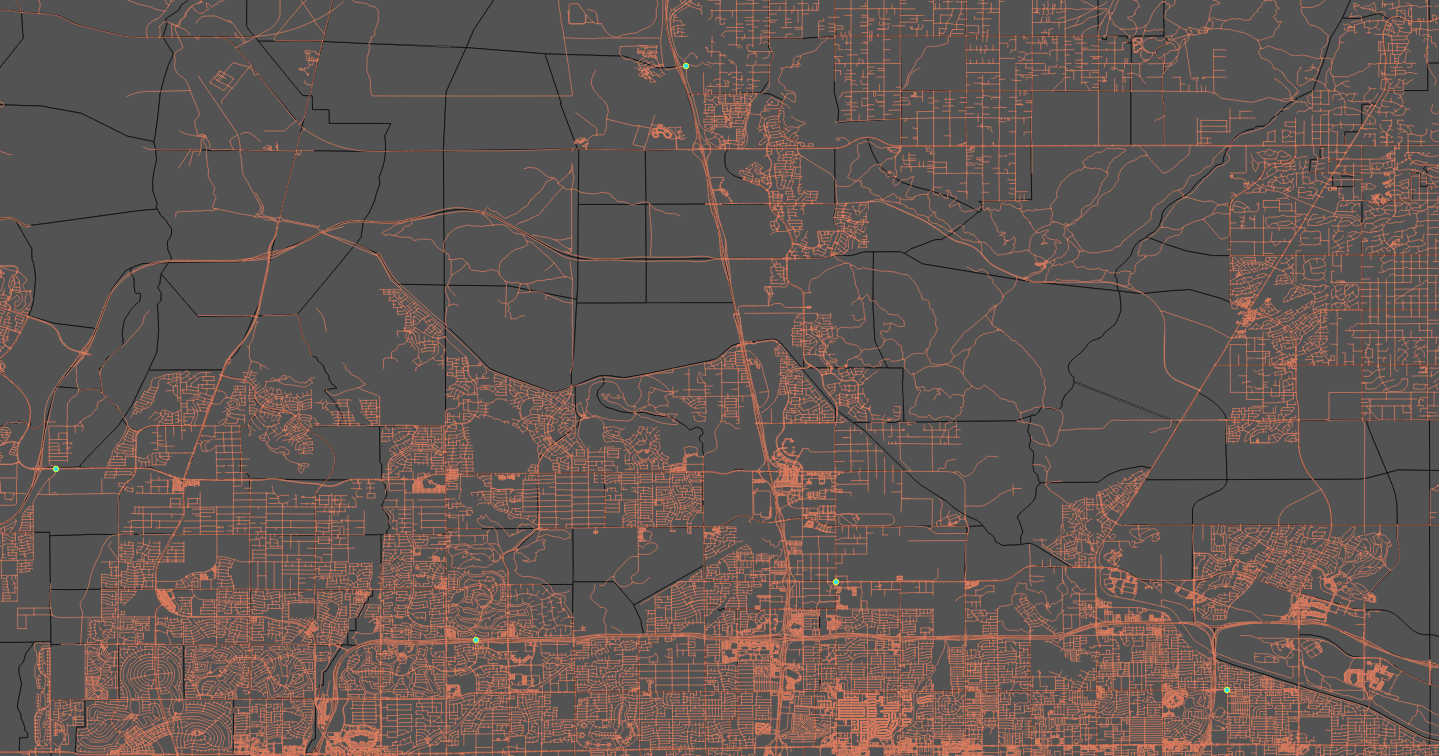

In [23]:
from IPython.display import Image
Image(filename='Strava_MAG_official_mar_apr_2016.png') 

### Next Steps in Pipeline

In [30]:
#Create the buffer of 100m around official bike count locations
gdf1 = gpd.read_file( official_counts + 'MAG_official_mar_apr_2016_buffer_100m_geodesic.shp')
#Select all edges and nodes falling within the buffer polygon
x = 
for item in gdf1:
    for item1 in mag2016_edges_strava:
        x.append(item1.geometry.within(item))
strava_edges_within = mag2016_edges_strava[mag2016_edges_strava.geometry.within(gdf1.geometry.buffer(100))]
strava_nodes_within = mag2016_nodes_strava[mag2016_nodes_strava.geometry.within(gdf1.geometry.buffer(100))]
#Take combined counts of cyclists from the streets and intersections in the selected area

#Compare the 

In [58]:
mag2016_nodes_strava[mag2016_nodes_strava.geometry.touches(gdf1.iloc[5].geometry)]

,ID,geometry


In [ ]:
mag_strava_mar_cyclists_100_edges = mag_strava_osm_edges_data.query("(day >= 90 | day <=102) & year == 2016 & athlete_count>0")
#Select these node_id and join with the edges & nodes separately
print(mag_strava_mar_cyclists_100_edges["athlete_count"].describe())
mag_strava_mar_cyclists_100_edges["athlete_count"].hist()

In [ ]:
#Dynamic histogram for checking the count of bicyclists in Strava 

### Test for randomness in the data using autocorrelation & lag plots

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(mag_strava_mar_cyclists_100_nodes["athletes"])
#plt.show(fig, figsize = ([15,10]))

In [ ]:
from pandas.plotting import lag_plot
lag_plot(mag_strava_mar_cyclists_100_nodes["athletes"])

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(mag_strava_mar_cyclists_100_edges["athlete_count"])

In [ ]:
from pandas.plotting import autocorrelation_plot
lag_plot(mag_strava_mar_cyclists_100_edges["athlete_count"])

### We join the node_ids and edge_ids from the above list to visualise the geographical locations of these streets and intersections on a map

In [ ]:
%time mag_strava_mar_cyclists_100_edges_joined_total = mag_strava_edges_2016_3_total.merge(mag_strava_mar_cyclists_100_edges, on = "edge_id")
%time mag_strava_mar_cyclists_100_edges_joined_weekday = mag_strava_edges_2016_3_weekday.merge(mag_strava_mar_cyclists_100_edges, on = "edge_id")
%time mag_strava_mar_cyclists_100_edges_joined_weekend = mag_strava_edges_2016_3_weekend.merge(mag_strava_mar_cyclists_100_edges, on = "edge_id")
%time mag_strava_mar_cyclists_100_nodes_joined_total = mag_strava_nodes_2016_3_total.merge(mag_strava_mar_cyclists_100_nodes, on = "node_id")
%time mag_strava_mar_cyclists_100_nodes_joined_weekday = mag_strava_nodes_2016_3_weekday.merge(mag_strava_mar_cyclists_100_nodes, on = "node_id")
%time mag_strava_mar_cyclists_100_nodes_joined_weekend = mag_strava_nodes_2016_3_weekend.merge(mag_strava_mar_cyclists_100_nodes, on = "node_id")

One time process to write the intermediate results to a csv

In [ ]:
#mag_strava_mar_cyclists_100_edges.to_csv(ride_data + "Analysis_Generated_Data/MAG_Strava_2016_3_cyclists_above_100_edges.csv")
#mag_strava_mar_cyclists_100_edges_joined_total.to_csv(ride_data + "Analysis_Generated_Data/MAG_Strava_edges_2016_3_total_rollup_join_cyclists_100_edges.csv")
#mag_strava_mar_cyclists_100_edges_joined_weekday.to_csv(ride_data + "Analysis_Generated_Data/MAG_Strava_edges_2016_3_weekday_rollup_join_cyclists_100_edges.csv")
#mag_strava_mar_cyclists_100_edges_joined_weekend.to_csv(ride_data + "Analysis_Generated_Data/MAG_Strava_edges_2016_3_weekend_rollup_join_cyclists_100_edges.csv")
#mag_strava_mar_cyclists_100_nodes_joined_total.to_csv(ride_data + "Analysis_Generated_Data/MAG_Strava_nodes_2016_3_total_rollup_join_cyclists_100_nodes.csv")
#mag_strava_mar_cyclists_100_nodes_joined_weekday.to_csv(ride_data + "Analysis_Generated_Data/MAG_Strava_nodes_2016_3_weekday_rollup_join_cyclists_100_nodes.csv")
#mag_strava_mar_cyclists_100_nodes_joined_weekend.to_csv(ride_data + "Analysis_Generated_Data/MAG_Strava_nodes_2016_3_weekend_rollup_join_cyclists_100_nodes.csv")

### Strava Time Frames

* On-Season: April 1–Oct 1 <br>

* Early AM hours: 12am–5:59am<br>
    * Labeled as _0 <br>
* AM hours: 6am—9:59 am<br>
    * Labeled as _1 <br>
* Mid-Day Hours: 10 am–2:59pm <br>
    * Labeled as _2 <br>
* Peak PM Hours: 3am–7:59pm <br>
    * Labeled as _3 <br>
* Evening Hours: 8pm–11:59pm <br>
    * Labeled as _4 <br>

##### In order to understand the metadata more clearly, we take a look at the Strava Time Frames that define the peak hours and seasons

In [ ]:
type(mag2015_16_official)

In [ ]:
mag2016_edges_strava[['ID','OSM_NAME']]

In [ ]:
mag_strava_mar_cyclists_100_edges_joined_weekday.head()

In [ ]:
mag_strava_mar_cyclists_100_edges.head()

In [ ]:
strava_2016_ride_nodes_rollup_total.head()

In [ ]:
#Get summary statistics about the total no of cyclists for all days in January 2016
strava_2016_ride_nodes_rollup_total["actcnt_0"].describe()

In [ ]:
# Official bike counts provided by MAG
# Date Range :  3/30/16 to 4/11/16
# Site ID: 25,39,55,64,69

MAG_mar_to_apr = 

In [ ]:
# Join the data and pick those nodes where no of cyclist exceeds 30

strava_mag_nodes_tot_30 = mag2016_nodes_strava.merge(strava_2016_ride_nodes_rollup_total, left_on="ID", right_on="node_id")
#(296811-nodes rollup,372466-nodes)
strava_mag_nodes_tot_30.head()
print(strava_mag_nodes_tot_30.shape)

In [ ]:
strava_mag_nodes_tot_30.head()

In [ ]:
strava_mag_nodes_tot_30.columns

In [ ]:
# Pick those nodes which have a total bike count >30df = strava_mag_nodes_tot_30.query("actcnt_0 >30")[["ID","actcnt_0"]]
print(df.shape)
df.head()

In [ ]:
#Plot the data 
%time
ax = mag2016_edges.plot(color='blue',figsize = [25,15],linewidth=2)
mag2016_od_poly.plot(ax=ax, color='grey')

In [ ]:
print(mag2016_edges.crs,mag2016_nodes.crs,mag2016_od_poly.crs)

In [ ]:
mag2016_edges.head()

In [ ]:
mag2016_nodes.head()

In [ ]:
mag2016_od_poly.head()

In [ ]:
# 

In [ ]:
#Read additional dbf files to display rollup data from Strava for each day
#mag2016_edges_rollup = mag2016_edges_subset[[0:100]]


In [ ]:
#Select the edges with bike counts above 100 on a weekday



In [ ]:
# Calculate correlations between CRD counts and STRAVA counts
df = vic2013_crd_strava_am[["CRD_AM_total","Strava_AM_total"]]
df.corr()

In [ ]:
df = vic2013_crd_strava_am[["CRD_7-8am","STRAVA_7-8am","CRD_8-9am","STRAVA_8-9am"]]
df.corr()

In [ ]:
from datetime import datetime
# Plot a time series to show the CRD counts vs Strava counts in the morning
vic2013_crd_strava_am.AM_Count_Date = pd.to_datetime(vic2013_crd_strava_am.AM_Count_Date)
vic2013_crd_strava_am.AM_Count_Date.head()

In [ ]:
vic2013_am_crd = vic2013_crd_strava_am[["CRD_AM_total", "AM_Count_Date"]]
vic2013_am_crd = vic2013_am_crd.set_index("AM_Count_Date")
vic2013_am_crd.plot()

In [ ]:
vic2013_am_crd['2013-07':'2013-11'].plot()

In [ ]:
vic2013_am_crd['2013-07-21':'2013-09-01'].plot()

In [ ]:
vic2013_crd_strava_pm = pd.read_csv(data+"Victoria_CRD_Strava_PM_counts_08_25_2017.csv")
print(vic2013_crd_strava_pm.shape)
print(vic2013_crd_strava_pm.head())

In [ ]:
df = vic2013_crd_strava_pm[["CRD_peak","STRAVA_peak"]]
df.corr()

In [ ]:
df = vic2013_crd_strava_pm[["CRD_3-4pm","STRAVA_3-4pm","CRD_4-5pm","STRAVA_4-5pm","CRD_5-6pm","STRAVA_5-6pm"]]
df.corr()

In [ ]:
# Fit a linear regression model to the CRD and Strava counts for peak hours

In [ ]:
#Strava ridership for weekdays

In [ ]:
#Strava ridership for weekends

In [3]:
path = "C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/maricopa_2016_ride/Edges/"
pd.read_csv(path + "maricopa_2016_ride_rollup_season_0_weekday.csv").tathcnt.sum()

4388428

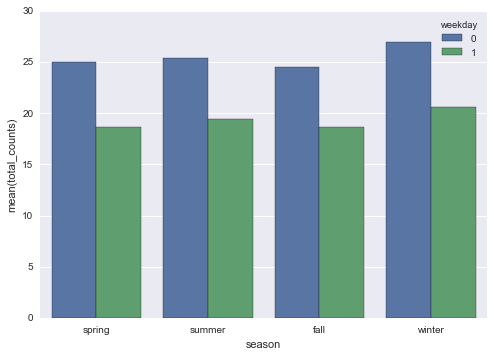

In [25]:
#Strava ridership for seasons
path = "C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/maricopa_2016_ride/Edges/"

edges_season0_weekend = pd.read_csv(path + "maricopa_2016_ride_rollup_season_0_weekend.csv").tathcnt.mean()
edges_season1_weekend = pd.read_csv(path + "maricopa_2016_ride_rollup_season_1_weekend.csv").tathcnt.mean()
edges_season2_weekend = pd.read_csv(path + "maricopa_2016_ride_rollup_season_2_weekend.csv").tathcnt.mean()
edges_season3_weekend = pd.read_csv(path + "maricopa_2016_ride_rollup_season_3_weekend.csv").tathcnt.mean()

edges_season0_weekday = pd.read_csv(path + "maricopa_2016_ride_rollup_season_0_weekday.csv").tathcnt.mean()
edges_season1_weekday = pd.read_csv(path + "maricopa_2016_ride_rollup_season_1_weekday.csv").tathcnt.mean()
edges_season2_weekday = pd.read_csv(path + "maricopa_2016_ride_rollup_season_2_weekday.csv").tathcnt.mean()
edges_season3_weekday = pd.read_csv(path + "maricopa_2016_ride_rollup_season_3_weekday.csv").tathcnt.mean()

total_counts = [edges_season0_weekday , edges_season1_weekday , edges_season2_weekday , edges_season3_weekday,edges_season0_weekend , edges_season1_weekend , edges_season2_weekend , edges_season3_weekend]
season = ['spring','summer','fall','winter']*2
weekday = [1,1,1,1,0,0,0,0]
import seaborn as sns
df = pd.DataFrame({'season': season, 'total_counts': total_counts, 'weekday': weekday})
sns.barplot(x="season",y="total_counts",data=df,hue="weekday")

In [29]:
df.query("weekday==1")

,season,total_counts,weekday
0,spring,18.665742,1
1,summer,19.425225,1
2,fall,18.667020,1
3,winter,20.584760,1


In [31]:
df.query("weekday==0")

,season,total_counts,weekday
4,spring,24.997823,0
5,summer,25.431834,0
6,fall,24.564919,0
7,winter,26.991758,0


In [32]:
24.997823-18.665742

6.332080999999999

[<matplotlib.text.Text at 0x642e3320>, <matplotlib.text.Text at 0x642e20f0>]

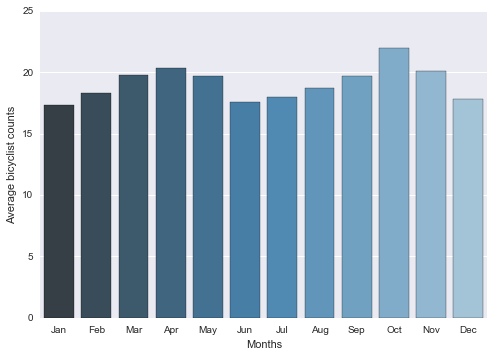

In [17]:
#Stacked barplot for monthly average counts
'''path = "C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/maricopa_2016_ride/Edges/"
jan = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_1_total.csv").tathcnt.mean()
feb = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_2_total.csv").tathcnt.mean()
mar = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_3_total.csv").tathcnt.mean()
apr = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_4_total.csv").tathcnt.mean()
may = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_5_total.csv").tathcnt.mean()
jun = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_6_total.csv").tathcnt.mean()
jul = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_7_total.csv").tathcnt.mean()
aug = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_8_total.csv").tathcnt.mean()
sep = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_9_total.csv").tathcnt.mean()
oct = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_10_total.csv").tathcnt.mean()
nov = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_11_total.csv").tathcnt.mean()
dec = pd.read_csv(path + "maricopa_2016_ride_rollup_month_2016_12_total.csv").tathcnt.mean()
monthly_counts = [jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec]'''
df = pd.DataFrame({'Months': ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 'monthly_counts': monthly_counts})
ax = sns.barplot(x="Months",y="monthly_counts",data=df, palette = 'Blues_d')
ax.set(xlabel="Months",ylabel="Average bicyclist counts")